In [29]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import numdifftools as nd
import scipy.optimize as optimize
from scipy.misc import derivative
import time

In [2]:
def generate_constant(m, n):
    # 単位行列In
    cov  = np.eye(n)
    # n次元ゼロベクトル
    mean = np.zeros(n)
    # (m,n)行列を作成
    A = np.random.multivariate_normal(mean, cov, size=m)

    # L-平滑のLを計算
    # LはAA^Tの最大固有値(Lmaxとする)以下であることを用いてLを生成
    val, vec = np.linalg.eig(np.dot(A, A.T))
    L = val[0].real
    return A, L

In [3]:
# logsumexp関数を定義
def f(x):
    sum = 0
    for a in A:
        sum += np.exp(np.dot(a.T, x) + 1)
    return np.log(sum)

# logsumexpの勾配を定義
def nabla_f(x):
    # 勾配の分母（スカラ）    
    denominator = 0
    # 勾配の分子（n次元ベクトル）
    nominator = 0
    for a in A:
        denominator += np.exp(np.dot(a.T, x) + 1)
        nominator += a * np.exp(np.dot(a.T, x) + 1)
    return nominator/denominator

# numdifftoolを使ってへシアンを計算
def hesse_f(x, f):
    hesse = nd.Hessian(f)
    return hesse(x)

In [4]:
# 最急降下法のstepsizeを返す関数
# (1)固定(L-平滑の定義を満たすL)
def stepsize1(L):
    return 1/L

# (2) exact line search
def stepsize2(x, f):
    # phi(alpha) = f(x + alpha * d)を定義( =数学的にはalphaの関数として)
    def phi(alpha, x):
        return f(x - alpha * nabla_f(x))
    # phiをalpha=1.0から始めて最小化する, argsは最適化に関係ない引数
    return optimize.minimize(phi, 1.0, args=x).x[0]

# (3) アルミホの規則を満たすステップサイズ
def stepsize3(x, f):
    # phi(alpha) = f(x + alpha * d)を定義( =数学的にはalphaの関数として)
    def phi(alpha):
        return f(x - alpha * nabla_f(x))
    
    # alphaの初期値と収縮率rho, アルミホ条件のcを定義
    alpha = 1.0
    rho = 0.75
    c = 0.9
    
    # phiをalpha=0において微分した値を求める．
    d_phi = derivative(phi, 0, dx=1e-05)
    
    # アルミホ条件を満たすalphaになるまでalphaを収縮していく
    while phi(alpha)-f(x) > c*alpha*d_phi:
        alpha *= rho
    return alpha

In [5]:
EPS = 10**(-8)
# 最急降下法
def steepest(x0, L, f, nabla_f, fstar=None, step=10000, stepsize_mode=1):
    cnt = step
    x = np.ndarray((step, n))
    f_history = np.ndarray((step))
    x[0] = x0
    if fstar is None:
        f_history[0] = f(x0)
    else:
        f_history[0] = f(x0) - fstar
    # メインの繰り返し
    for i in range(step):
        if i == 0:
            continue
        
        # stepsizeを決める
        if stepsize_mode == 1:
            alpha = stepsize1(L)
        elif stepsize_mode == 2:
            alpha = stepsize2(x[i], f)
        elif stepsize_mode == 3:
            alpha = stepsize3(x[i], f)
            
        # xの値を更新
        x[i] = x[i-1] - nabla_f(x[i-1]) * alpha
        if fstar is None:
            f_history[i] = f(x[i])
        else:
            f_history[i] = f(x[i]) - fstar
        if fstar is not None:
            if f_history[i] <= EPS:
                cnt = i
                break
        else:
            if np.linalg.norm(nabla_f(x[i])) <= EPS:
                cnt = i
                break
    return f_history[:cnt], cnt

# Newton法
def newton(x0, f, nabla_f, hesse_f, fstar=None, step=10000):
    cnt = step
    x = np.ndarray((step, n))
    f_history = np.ndarray((step))
    x[0] = x0
    if fstar is None:
        f_history[0] = f(x0)
    else:
        f_history[0] = f(x0) - fstar
    # メインの繰り返し
    for i in range(step):
        if i == 0:
            continue
        x[i] = x[i-1] - np.dot(np.linalg.inv(hesse_f(x[i-1], f)), nabla_f(x[i-1]))
        if fstar is None:
            f_history[i] = f(x[i])
        else:
            f_history[i] = f(x[i]) - fstar
        # 終了条件の判定
        if fstar is not None:
            # if f_history[i] <= EPS: # 最適値との差分で終了条件を判定
            lamb = np.dot(nabla_f(x[i-1]).T, np.linalg.inv(hesse_f(x[i-1], f)))
            lamb = np.dot(lamb, nabla_f(x[i-1]))
            if lamb <= 2*EPS:  # Neewton's decrementで終了条件を判定
                cnt = i
                break
        else:
            if np.linalg.norm(nabla_f(x[i])) <= EPS:
                cnt = i
                break
    return f_history[:cnt], cnt

# Nesterovの加速
def nesterov(x0, L, f, nabla_f, fstar=None, step=10000):
    cnt = step
    x = np.ndarray((step, n))
    y = np.ndarray((step, n))
    f_history = np.ndarray((step))
    x[0], y[0] = x0, x0
    p_lam = 0
    if fstar is None:
        f_history[0] = f(x0)
    else:
        f_history[0] = f(x0) - fstar
    # メインの繰り返し
    for i in range(step):
        if i == 0:
            continue
        # 慣性項の係数gammaの計算
        lam = (1+np.sqrt(1+4*p_lam*p_lam))/2
        gamma = (p_lam-1)/lam
        p_lam = lam
        # steepestからの主な変更点
        y[i] = x[i-1] - nabla_f(x[i-1]) / L
        x[i] = y[i] + gamma * (y[i] - y[i-1])
        if fstar is None:
            f_history[i] = f(x[i])
        else:
            f_history[i] = f(x[i]) - fstar
        if fstar is not None:
            if f_history[i] <= EPS:
                cnt = i
                break
        else:
            if np.linalg.norm(nabla_f(x[i])) <= EPS:
                cnt = i
                break
    return f_history[:cnt], cnt

# (m, n) = (100, 10)

In [31]:
# 一旦最小値fstarを計算する
m,n = 100, 10
# 初期点x0を標準正規分布から生成
x0 = np.random.randn(n)
# m,nを設定しAとLを生成
A, L = generate_constant(m, n)
# まずはNesterovの加速で最小値を出す
f_history_ne, _ = nesterov(x0, L, f, nabla_f)
# 最小値を保存
fstar = f_history_ne[-1]
print("fstar = ", fstar)

fstar =  5.564818365425315


In [36]:
# newton法だと初期値によって収束しないので，0に近い初期値にしておく
x0 = np.zeros(n)

# Newton法
s_time = time.time()
diff_history_nw, cnt_nw = newton(x0, f, nabla_f, hesse_f, fstar)
time_nw = time.time() - s_time
print("nw iter count = {} ({} sec)".format(cnt_nw, time_nw))

# 最急降下法(ステップサイズ固定)
s_time = time.time()
diff_history_1, cnt_1 = steepest(x0, L, f, nabla_f, fstar, stepsize_mode=1)
time_1 = time.time() - s_time
print("gd iter count(stepsize=1/L) = {} ({} sec)".format(cnt_1, time_1))

# 最急降下法(厳密な直線探索)
s_time = time.time()
diff_history_2, cnt_2 = steepest(x0, L, f, nabla_f, fstar, stepsize_mode=2)
time_2 = time.time() - s_time
print("gd iter count(stepsize: exact line search) = {} ({} sec)".format(cnt_2, time_2))

# 最急降下法(アルミホ条件)
s_time = time.time()
diff_history_3, cnt_3 = steepest(x0, L, f, nabla_f, fstar, stepsize_mode=3)
time_3 = time.time() - s_time
print("gd iter count(stepsize: armijo) = {} ({} sec)".format(cnt_3, time_3))

nw iter count = 3 (2.4447948932647705 sec)
gd iter count(stepsize=1/L) = 2168 (1.071012020111084 sec)
gd iter count(stepsize: exact line search) = 11 (0.05182600021362305 sec)
gd iter count(stepsize: armijo) = 43 (0.25528979301452637 sec)


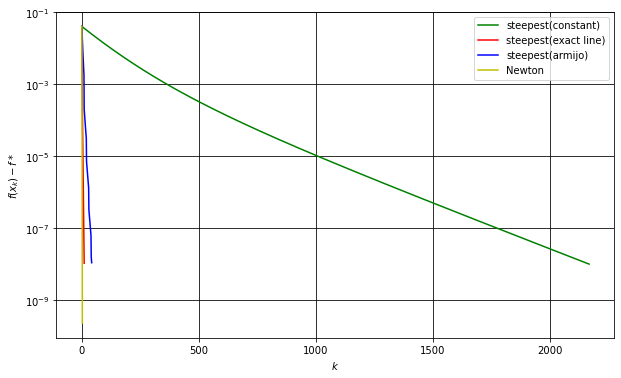

In [37]:
x_1 = np.array(range(cnt_1))
x_2 = np.array(range(cnt_2))
x_3 = np.array(range(cnt_3))
x_nw = np.array(range(cnt_nw))
# fの値の変化をプロット, y軸を対数めもりにする
plt.figure(figsize=(10,6))
plt.yscale('log')
plt.xlabel('$k$')
plt.ylabel('$f(x_k)-f*$')
plt.grid(which='major',color='black',linestyle='-')
plt.plot(x_1, diff_history_1, color='g', label='steepest(constant)')
plt.plot(x_2, diff_history_2, color='r', label='steepest(exact line)')
plt.plot(x_3, diff_history_3, color='b', label='steepest(armijo)')
plt.plot(x_nw, diff_history_nw, color='y', label='Newton')
plt.legend()
plt.show()

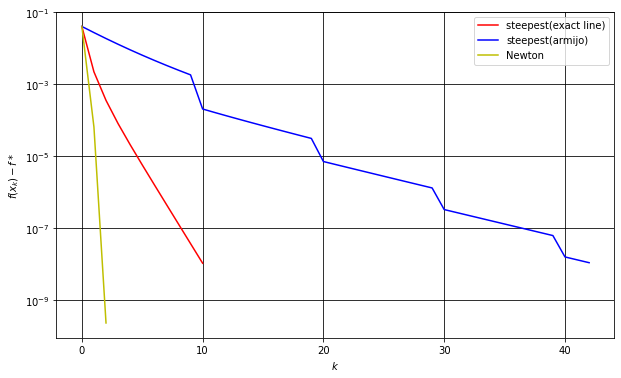

In [39]:
"""
stepsize = constant は遅すぎて論外なのでそれ以外のものだけで比較
"""

# x_1 = np.array(range(cnt_1))
x_2 = np.array(range(cnt_2))
x_3 = np.array(range(cnt_3))
x_nw = np.array(range(cnt_nw))
# fの値の変化をプロット, y軸を対数めもりにする
plt.figure(figsize=(10,6))
plt.yscale('log')
plt.xlabel('$k$')
plt.ylabel('$f(x_k)-f*$')
plt.grid(which='major',color='black',linestyle='-')
# plt.plot(x_1, diff_history_1, color='g', label='steepest(constant)')
plt.plot(x_2, diff_history_2, color='r', label='steepest(exact line)')
plt.plot(x_3, diff_history_3, color='b', label='steepest(armijo)')
plt.plot(x_nw, diff_history_nw, color='y', label='Newton')
plt.legend()
plt.show()

# (m, n) = (500, 50)

In [48]:
m,n = 500, 50
# 初期点x0を標準正規分布から生成
x0 = np.random.randn(n)
# m,nを設定しAとLを生成
A, L = generate_constant(m, n)
# まずはNesterovの加速で最小値を出す
f_history_ne, _ = nesterov(x0, L, f, nabla_f)
# 最小値を保存
fstar = f_history_ne[-1]
print("fstar = ", fstar)

fstar =  7.153862016582137


In [49]:
# newton法だと初期値によって収束しないので，0に近い初期値にしておく
x0 = np.zeros(n)

# Newton法
s_time = time.time()
diff_history_nw, cnt_nw = newton(x0, f, nabla_f, hesse_f, fstar)
time_nw = time.time() - s_time
print("nw iter count = {} ({} sec)".format(cnt_nw, time_nw))

# 最急降下法(ステップサイズ固定)
s_time = time.time()
diff_history_1, cnt_1 = steepest(x0, L, f, nabla_f, fstar, stepsize_mode=1)
time_1 = time.time() - s_time
print("gd iter count(stepsize=1/L) = {} ({} sec)".format(cnt_1, time_1))

# 最急降下法(厳密な直線探索)
s_time = time.time()
diff_history_2, cnt_2 = steepest(x0, L, f, nabla_f, fstar, stepsize_mode=2)
time_2 = time.time() - s_time
print("gd iter count(stepsize: exact line search) = {} ({} sec)".format(cnt_2, time_2))

# 最急降下法(アルミホ条件)
s_time = time.time()
diff_history_3, cnt_3 = steepest(x0, L, f, nabla_f, fstar, stepsize_mode=3)
time_3 = time.time() - s_time
print("gd iter count(stepsize: armijo) = {} ({} sec)".format(cnt_3, time_3))

nw iter count = 4 (388.0249352455139 sec)
gd iter count(stepsize=1/L) = 10000 (24.005951166152954 sec)
gd iter count(stepsize: exact line search) = 27 (0.994178056716919 sec)
gd iter count(stepsize: armijo) = 76 (2.3572516441345215 sec)


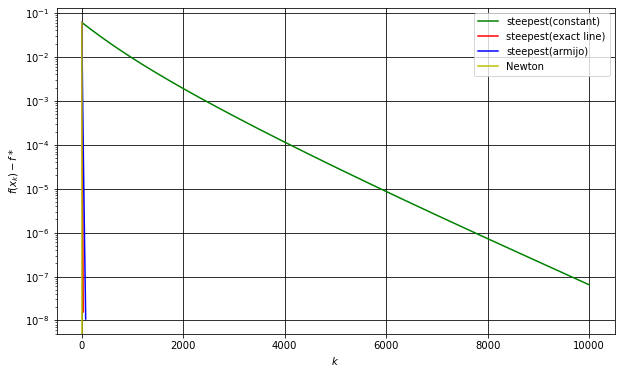

In [50]:
x_1 = np.array(range(cnt_1))
x_2 = np.array(range(cnt_2))
x_3 = np.array(range(cnt_3))
x_nw = np.array(range(cnt_nw))
# fの値の変化をプロット, y軸を対数めもりにする
plt.figure(figsize=(10,6))
plt.yscale('log')
plt.xlabel('$k$')
plt.ylabel('$f(x_k)-f*$')
plt.grid(which='major',color='black',linestyle='-')
plt.plot(x_1, diff_history_1, color='g', label='steepest(constant)')
plt.plot(x_2, diff_history_2, color='r', label='steepest(exact line)')
plt.plot(x_3, diff_history_3, color='b', label='steepest(armijo)')
plt.plot(x_nw, diff_history_nw, color='y', label='Newton')
plt.legend()
plt.show()

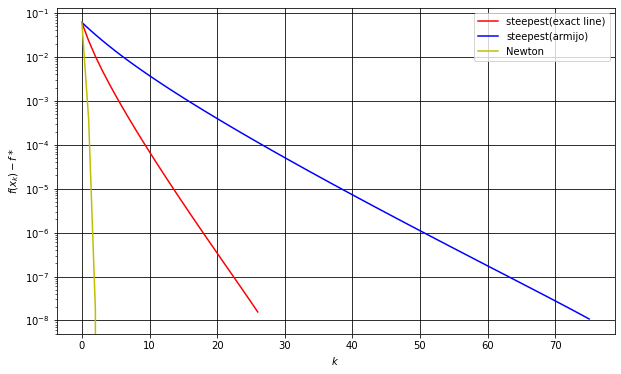

In [51]:
"""
stepsize = constant は遅すぎて論外なのでそれ以外のものだけで比較
"""

# x_1 = np.array(range(cnt_1))
x_2 = np.array(range(cnt_2))
x_3 = np.array(range(cnt_3))
x_nw = np.array(range(cnt_nw))
# fの値の変化をプロット, y軸を対数めもりにする
plt.figure(figsize=(10,6))
plt.yscale('log')
plt.xlabel('$k$')
plt.ylabel('$f(x_k)-f*$')
plt.grid(which='major',color='black',linestyle='-')
# plt.plot(x_1, diff_history_1, color='g', label='steepest(constant)')
plt.plot(x_2, diff_history_2, color='r', label='steepest(exact line)')
plt.plot(x_3, diff_history_3, color='b', label='steepest(armijo)')
plt.plot(x_nw, diff_history_nw, color='y', label='Newton')
plt.legend()
plt.show()